In [139]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import csv
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
url = 'https://coinmarketcap.com/historical/20250928/'
response = requests.get(url)
html_content = response.text
response

<Response [200]>

In [7]:
scraper = BeautifulSoup(html_content, 'html.parser')

In [105]:
table = scraper.find_all('table')[2]
rows = table.find_all('tr')
headers = [header.text.strip() for header in table.find_all('th')]
for i in range(1, min(len(rows), 21)):
    row = rows[i]
    cells = [cell.text.strip() for cell in row.find_all('td')]
    if cells:
        data = dict(zip(headers, cells))
        print(data)

{'Rank': '1', 'Name': 'BTCBitcoin', 'Symbol': 'BTC', 'Market Cap': '$2,234,315,482,475.94', 'Price': '$112,122.64', 'Circulating Supply': '19,927,425 BTC', 'volume (24h)': '$33,371,048,505.29', '% 1h': '0.13%', '% 24h': '2.23%', '% 7d': '-2.76%', '': ''}
{'Rank': '2', 'Name': 'ETHEthereum', 'Symbol': 'ETH', 'Market Cap': '$499,889,895,731.15', 'Price': '$4,141.48', 'Circulating Supply': '120,703,304 ETH *', 'volume (24h)': '$24,631,307,053.80', '% 1h': '0.18%', '% 24h': '3.06%', '% 7d': '-6.96%', '': ''}
{'Rank': '3', 'Name': 'USDTTether USDt', 'Symbol': 'USDT', 'Market Cap': '$174,433,110,379.69', 'Price': '$1.0003', 'Circulating Supply': '174,372,128,682 USDT *', 'volume (24h)': '$92,130,856,740.41', '% 1h': '<0.01%', '% 24h': '-0.01%', '% 7d': '-0.01%', '': ''}
{'Rank': '4', 'Name': 'XRPXRP', 'Symbol': 'XRP', 'Market Cap': '$171,497,811,439.19', 'Price': '$2.8666', 'Circulating Supply': '59,826,504,399 XRP *', 'volume (24h)': '$3,306,243,728.40', '% 1h': '0.23%', '% 24h': '2.10%', '

In [106]:
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    table = scraper.find_all('table')[2]
    rows = table.find_all('tr')
    headers = [header.text.strip() for header in table.find_all('th')]
    for i in range(1, min(len(rows), 21)):
        row = rows[i]
        cells = [cell.text.strip() for cell in row.find_all('td')]
        if cells:
            writer.writerow(cells)

In [107]:
df = pd.read_csv('output.csv')

In [108]:
df.head(5)

,Rank,Name,Symbol,Market Cap,Price,Circulating Supply,volume (24h),% 1h,% 24h,% 7d,Unnamed: 10
0,1,BTCBitcoin,BTC,"$2,234,315,482,475.94","$112,122.64","19,927,425 BTC","$33,371,048,505.29",0.13%,2.23%,-2.76%,NaN
1,2,ETHEthereum,ETH,"$499,889,895,731.15","$4,141.48","120,703,304 ETH *","$24,631,307,053.80",0.18%,3.06%,-6.96%,NaN
2,3,USDTTether USDt,USDT,"$174,433,110,379.69",$1.0003,"174,372,128,682 USDT *","$92,130,856,740.41",<0.01%,-0.01%,-0.01%,NaN
3,4,XRPXRP,XRP,"$171,497,811,439.19",$2.8666,"59,826,504,399 XRP *","$3,306,243,728.40",0.23%,2.10%,-3.59%,NaN
4,5,BNBBNB,BNB,"$138,255,254,206.45",$993.32,"139,185,630 BNB *","$2,519,459,113.18",0.42%,2.53%,-5.28%,NaN


In [109]:
df.drop(['Unnamed: 10'], axis=1, inplace=True)

In [112]:
df_pca = df.drop(['Name'], axis=1)
df_pca = df_pca.drop(['Symbol'], axis=1)
df_pca = df_pca.drop(['Rank'], axis=1)
for col in df_pca.columns:
    if df_pca[col].dtype == 'object':
        df_pca[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))

In [113]:
df_pca.head()

,Market Cap,Price,Circulating Supply,volume (24h),% 1h,% 24h,% 7d
0,2234315482475.94,112122.64,19927425,33371048505.29,0.13,2.23,-2.76
1,499889895731.15,4141.48,120703304,24631307053.80,0.18,3.06,-6.96
2,174433110379.69,1.0003,174372128682,92130856740.41,0.01,-0.01,-0.01
3,171497811439.19,2.8666,59826504399,3306243728.40,0.23,2.10,-3.59
4,138255254206.45,993.32,139185630,2519459113.18,0.42,2.53,-5.28


In [114]:
scaler = StandardScaler()
df_pca = scaler.fit_transform(df_pca)

In [91]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [115]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['Symbol'] = df['Symbol']
pca_df['Name'] = df['Name']

In [119]:
print("\nPCA Explained Variance Ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"\nCumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")


PCA Explained Variance Ratio:
PC1: 0.3537 (35.37%)
PC2: 0.2915 (29.15%)
PC3: 0.1894 (18.94%)
PC4: 0.0795 (7.95%)
PC5: 0.0450 (4.50%)
PC6: 0.0284 (2.84%)
PC7: 0.0118 (1.18%)
PC8: 0.0008 (0.08%)

Cumulative explained variance: [0.35368107 0.64517808 0.83456203 0.9140228  0.95900817 0.98742905
 0.99918439 1.        ]


Text(0.5, 1.0, 'Scree Plot')

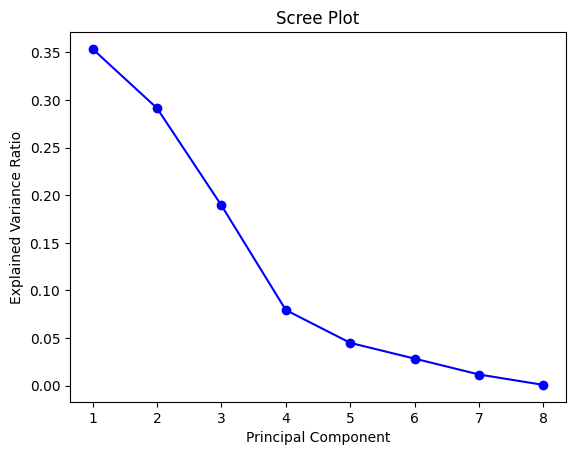

In [129]:
plt.subplot(1, 1, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

Text(0.5, 1.0, 'PCA - First Two Components')

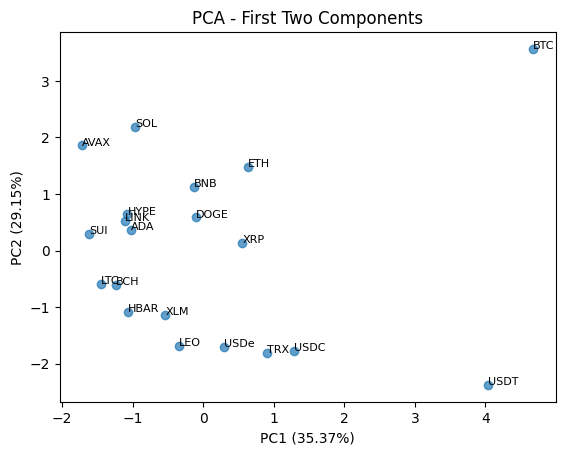

In [128]:
plt.subplot(1, 1, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
for i, symbol in enumerate(pca_df['Symbol']):
    plt.annotate(symbol, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=8)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA - First Two Components')

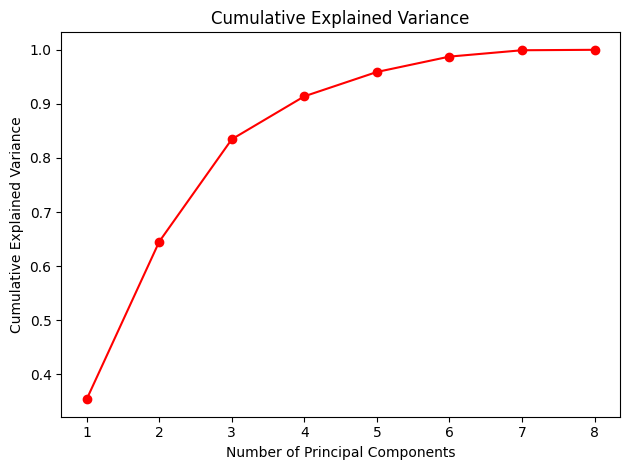

In [130]:
plt.subplot(1, 1, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')

plt.tight_layout()
plt.show()


In [131]:
kmeans = KMeans(n_clusters=3, random_state=42)
crypto_types = kmeans.fit_predict(df_pca)

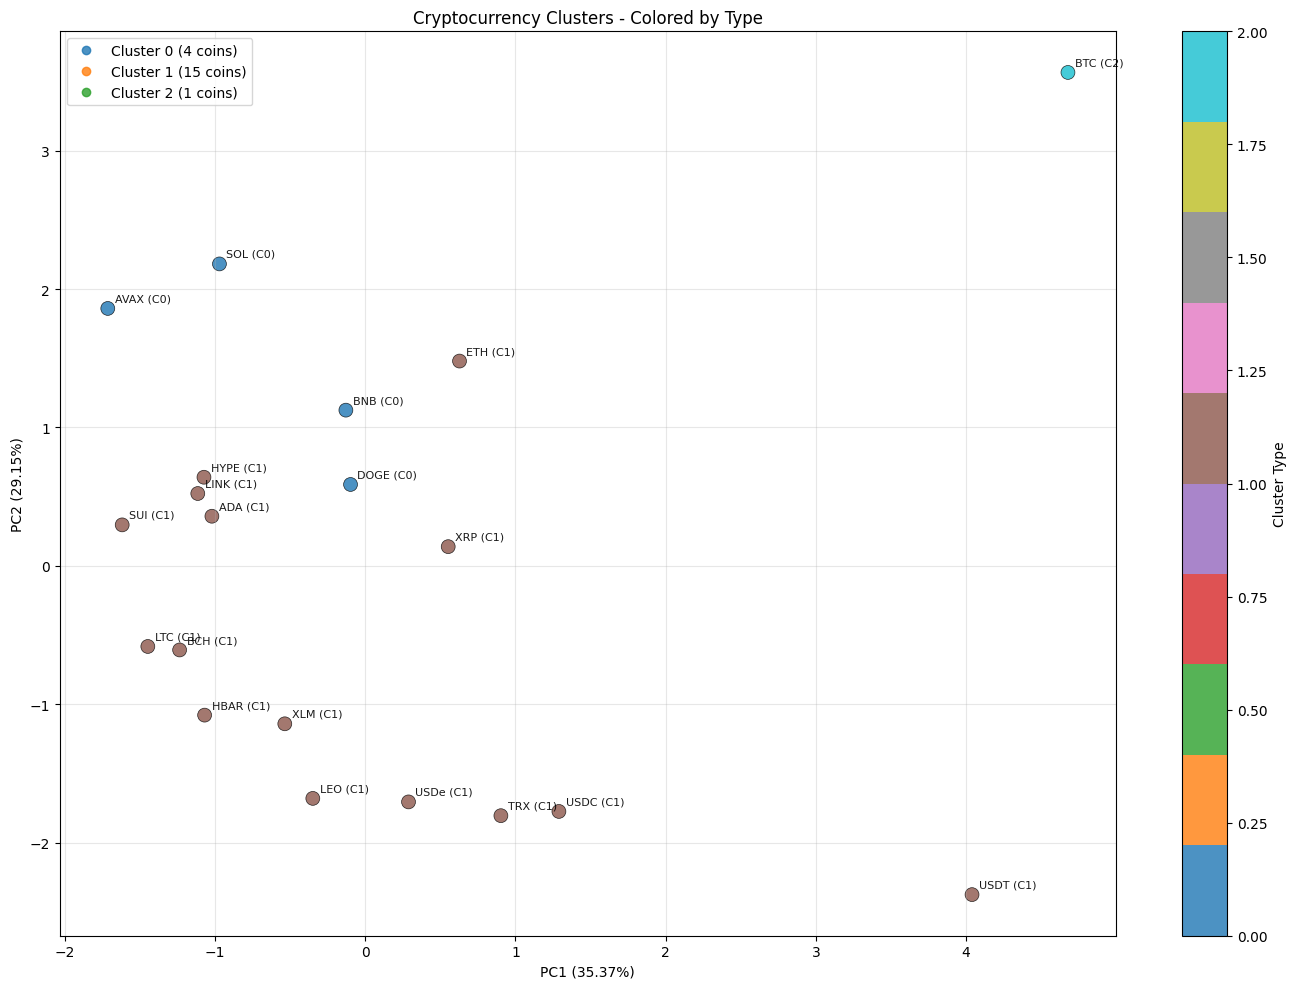

Cluster Assignments:
Cluster 0: ['BNB', 'SOL', 'DOGE', 'AVAX']
Cluster 1: ['ETH', 'USDT', 'XRP', 'USDC', 'TRX', 'ADA', 'HYPE', 'LINK', 'USDe', 'XLM', 'SUI', 'BCH', 'HBAR', 'LEO', 'LTC']
Cluster 2: ['BTC']


In [141]:
# Create a more detailed plot with cluster information
plt.figure(figsize=(14, 10))

# Define colors for each cluster
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Add more if you have more clusters

scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=crypto_types, 
                     cmap='tab10',
                     alpha=0.8, 
                     s=100,
                     edgecolors='black',
                     linewidth=0.5)

# Add labels with cluster info
for i, (symbol, cluster) in enumerate(zip(pca_df['Symbol'], crypto_types)):
    plt.annotate(f'{symbol} (C{cluster})', 
                (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), 
                fontsize=8, 
                alpha=0.9,
                xytext=(5, 5),
                textcoords='offset points')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Cryptocurrency Clusters - Colored by Type')
plt.colorbar(scatter, label='Cluster Type')

# Add cluster legend
cluster_types = sorted(set(crypto_types))
for cluster in cluster_types:
    cluster_count = sum(crypto_types == cluster)
    plt.plot([], [], 'o', alpha=0.8, label=f'Cluster {cluster} ({cluster_count} coins)')
plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print cluster assignments
print("Cluster Assignments:")
for cluster in sorted(set(crypto_types)):
    cluster_coins = pca_df['Symbol'][crypto_types == cluster].tolist()
    print(f"Cluster {cluster}: {cluster_coins}")

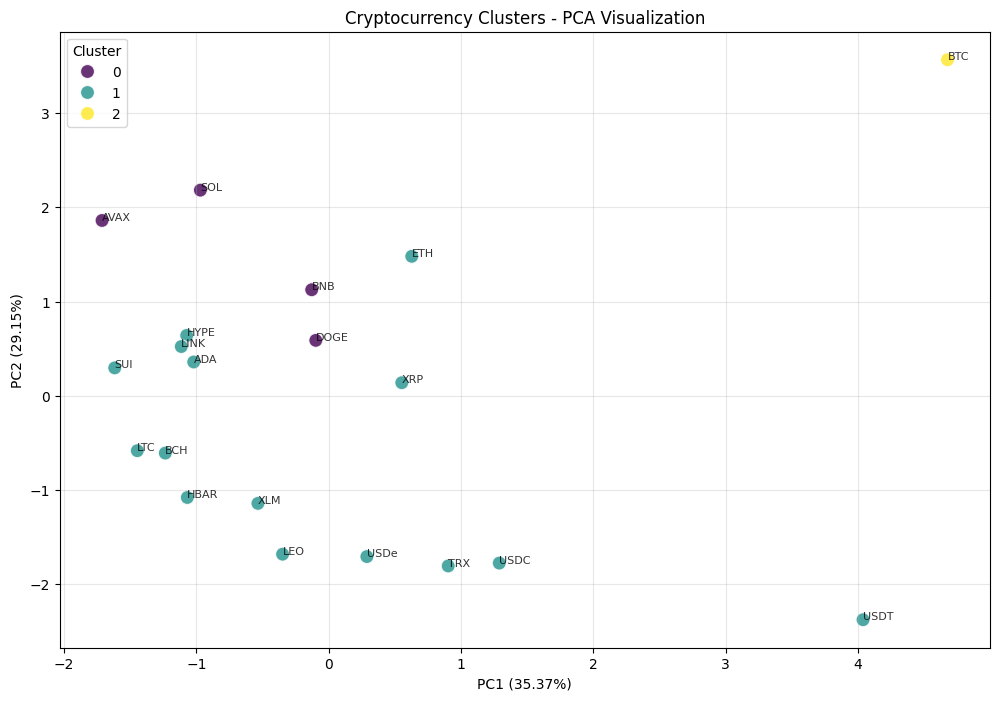

In [140]:
plt.figure(figsize=(12, 8))

# Convert to DataFrame for seaborn
plot_df = pca_df[['PC1', 'PC2', 'Symbol']].copy()
plot_df['Cluster'] = crypto_types

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=100, alpha=0.8)

# Add labels
for i, row in plot_df.iterrows():
    plt.annotate(row['Symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Cryptocurrency Clusters - PCA Visualization')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()